# Stock Market Forecasting

## Importing Relevant Libraries

In [140]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

## Reading In Data

In [141]:
ticker = 'IOZ.AX'
data = yf.Ticker(ticker)

## Data for 1 month

In [142]:
closed_prices_1month = data.history(period='1mo')['Close']
returns = closed_prices_1month.pct_change().dropna()

### EDA

Text(0, 0.5, 'Closed Prices')

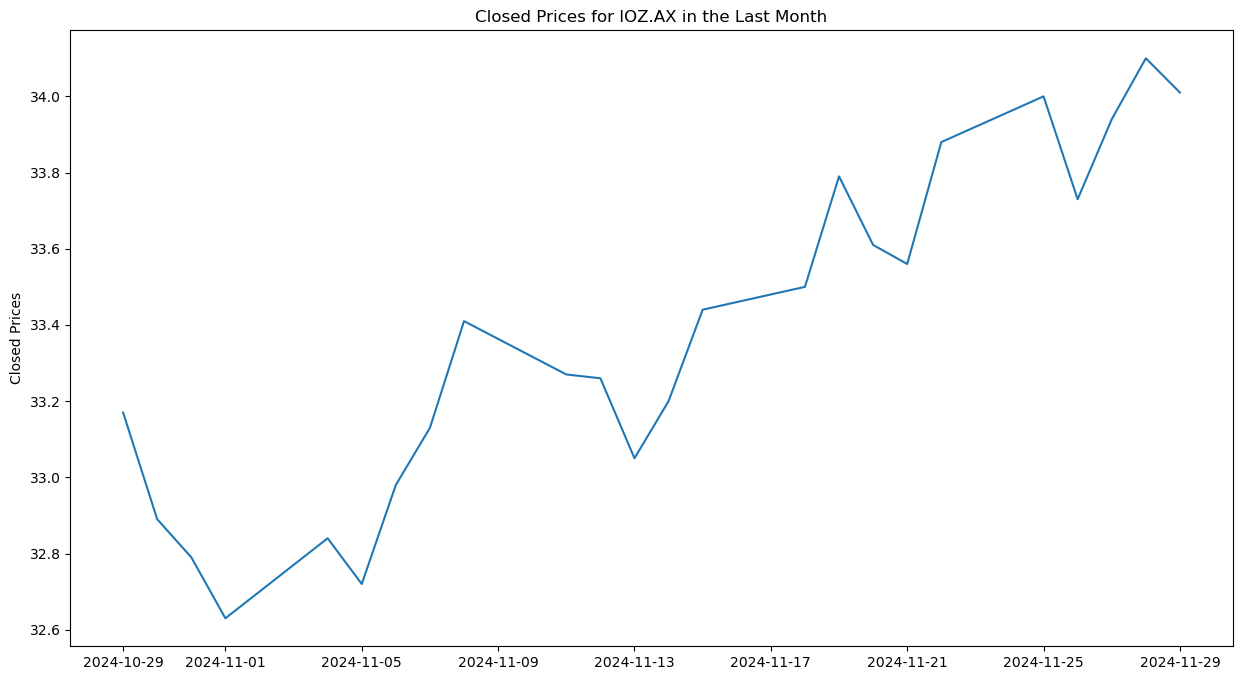

In [143]:
plt.figure(figsize=(15, 8))
plt.plot(closed_prices_1month)
plt.title('Closed Prices for IOZ.AX in the Last Month')
plt.ylabel('Closed Prices')

#### ACF and PACF Plots

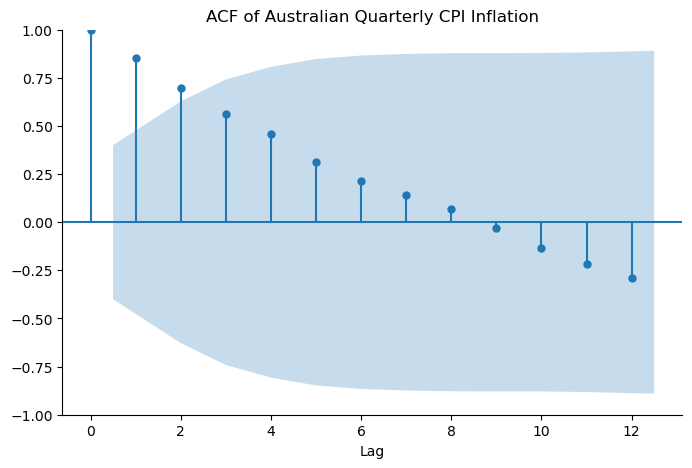

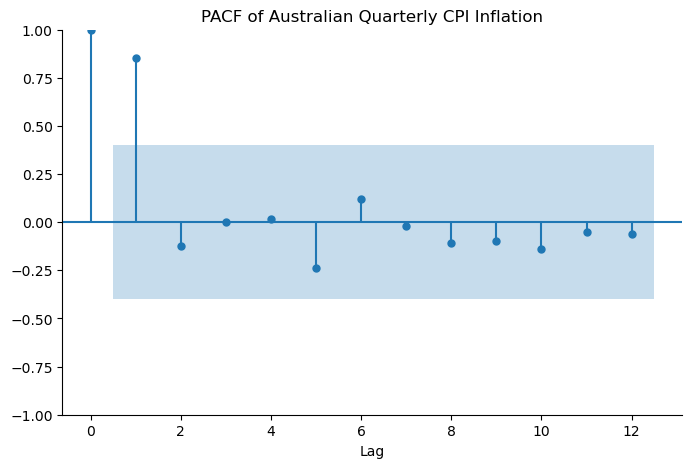

In [144]:
# ACF plots of the CPI data for 12 lags
fig_stock_acf, ax_stock_acf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(closed_prices_1month, lags=12,
                         ax=ax_stock_acf, alpha=0.05)
ax_stock_acf.set_xlabel('Lag')
ax_stock_acf.set_title('ACF of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

# PACF plots of the CPI data for 12 lags
fig_stock_pacf, ax_stock_pacf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_pacf(closed_prices_1month, lags=12,
                          ax=ax_stock_pacf, alpha=0.05)
ax_stock_pacf.set_xlabel('Lag')
ax_stock_pacf.set_title('PACF of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

### Model Development

#### Time Series Decomposition

In [145]:
window_size = 12
decomposition = seasonal_decompose(
    closed_prices_1month, model='additive', period=4, filt=np.repeat(1/window_size, window_size))

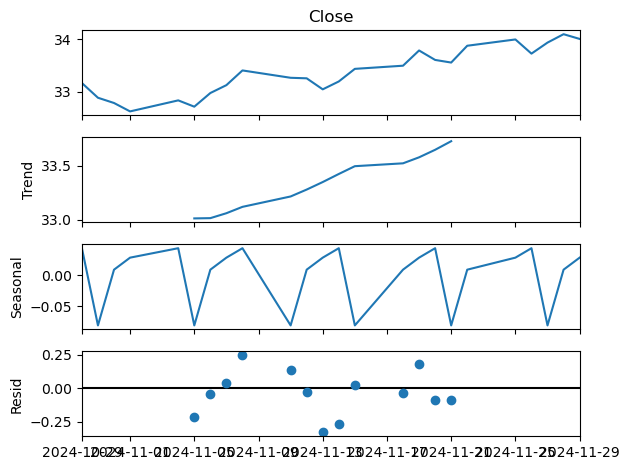

In [146]:
decomposition.plot()
plt.show()

#### Testing for Stationary Points

In [147]:
def test_stationarity(timeseries):

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    if dftest[0] < dftest[4]["5%"]:
        print('Reject H0 - Time Series is stationary')
    else:
        print('Failed to reject H0 - Time series is non-stationary')


test_stationarity(closed_prices_1month)

Results of Dickey-Fuller Test:
Test Statistic                  1.402807
p-value                         0.997127
#Lags Used                      9.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64
Failed to reject H0 - Time series is non-stationary


#### SARIMA Model

In [148]:
sarima_model_aic = pm.auto_arima(closed_prices_1month, seasonal=True, m=12,
                                 information_criterion='aic', test='adf',
                                 suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4.115, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=32.296, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-3.445, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=238.482, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-3.849, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-2.160, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-1.845, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-1.847, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=16.186, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=0.136, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.164 seconds


In [149]:
sarima_model_aic.set_params()

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [150]:
sarima_model_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                   4.924
Date:                Fri, 29 Nov 2024   AIC                             -3.849
Time:                        16:23:01   BIC                             -0.315
Sample:                    10-29-2024   HQIC                            -2.911
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0846      3.288      0.938      0.348      -3.360       9.529
ar.L1          0.9078      0.098      9.225      0.000       0.715       1.101
sigma2         0.0361      0.020      1.838      0.066      -0.002       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.88   Prob(JB):                         0.39
Heteroskedasticity (H):               1.08   Skew:                            -0.04
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
sarima_model_bic = pm.auto_arima(closed_prices_1month, seasonal=True, m=12,
                                 information_criterion='bic', test='adf',
                                 suppress_warnings=True, trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=13.540, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=34.652, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=1.267, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=239.660, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=-0.315, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=3.730, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=2.868, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=2.865, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=19.720, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=6.026, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 3.123 seconds


In [152]:
sarima_model_bic.set_params()

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [153]:
sarima_model_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                   4.924
Date:                Fri, 29 Nov 2024   AIC                             -3.849
Time:                        16:23:04   BIC                             -0.315
Sample:                    10-29-2024   HQIC                            -2.911
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0846      3.288      0.938      0.348      -3.360       9.529
ar.L1          0.9078      0.098      9.225      0.000       0.715       1.101
sigma2         0.0361      0.020      1.838      0.066      -0.002       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.88   Prob(JB):                         0.39
Heteroskedasticity (H):               1.08   Skew:                            -0.04
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [154]:
sarima_aic_model = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                            suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month)
sarima_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                   4.924
Date:                Fri, 29 Nov 2024   AIC                             -3.849
Time:                        16:23:04   BIC                             -0.315
Sample:                    10-29-2024   HQIC                            -2.911
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0846      3.288      0.938      0.348      -3.360       9.529
ar.L1          0.9078      0.098      9.225      0.000       0.715       1.101
sigma2         0.0361      0.020      1.838      0.066      -0.002       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.88   Prob(JB):                         0.39
Heteroskedasticity (H):               1.08   Skew:                            -0.04
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [193]:
sarima_aic_model.predict(n_periods=20)

2024-12-02 00:00:00+11:00    33.960091
2024-12-03 00:00:00+11:00    33.914784
2024-12-04 00:00:00+11:00    33.873653
2024-12-05 00:00:00+11:00    33.836312
2024-12-06 00:00:00+11:00    33.802413
2024-12-09 00:00:00+11:00    33.771637
2024-12-10 00:00:00+11:00    33.743699
2024-12-11 00:00:00+11:00    33.718335
2024-12-12 00:00:00+11:00    33.695309
2024-12-13 00:00:00+11:00    33.674405
2024-12-16 00:00:00+11:00    33.655427
2024-12-17 00:00:00+11:00    33.638199
2024-12-18 00:00:00+11:00    33.622558
2024-12-19 00:00:00+11:00    33.608359
2024-12-20 00:00:00+11:00    33.595469
2024-12-23 00:00:00+11:00    33.583766
2024-12-24 00:00:00+11:00    33.573142
2024-12-25 00:00:00+11:00    33.563498
2024-12-26 00:00:00+11:00    33.554742
2024-12-27 00:00:00+11:00    33.546793
Freq: B, dtype: float64

##### Model Diagnosis

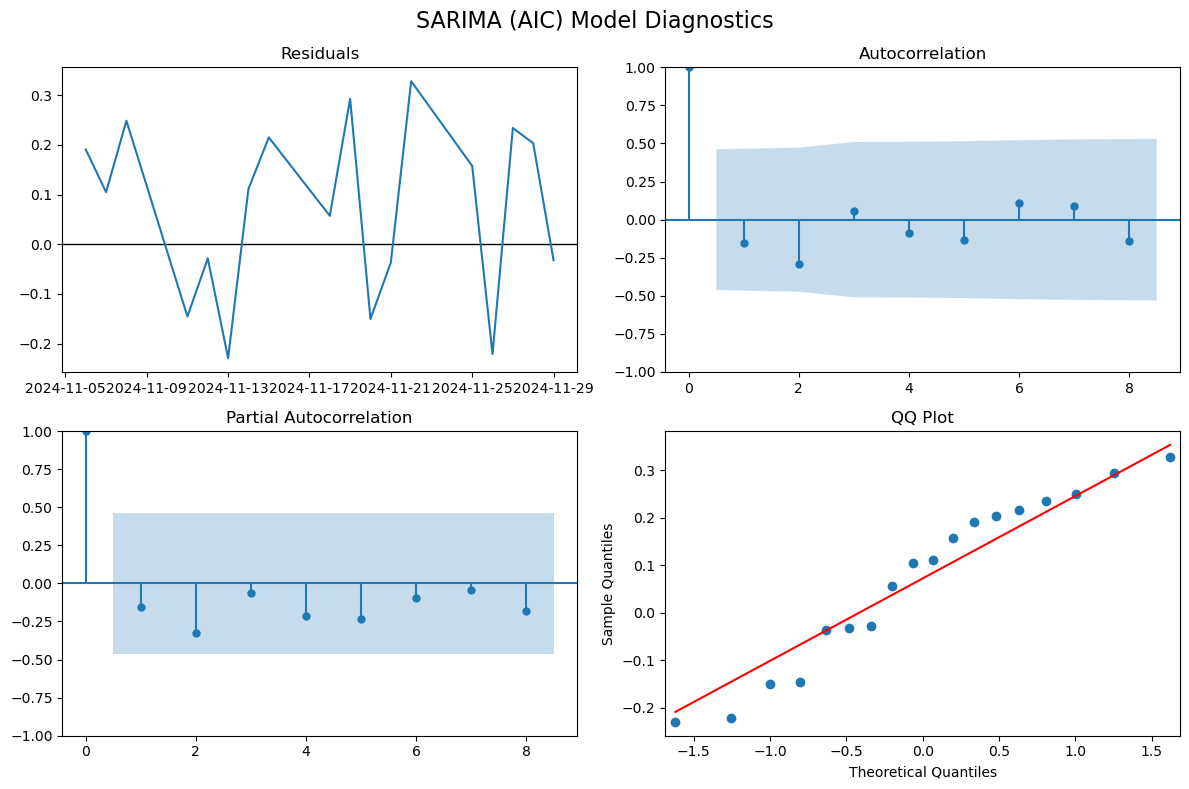

In [155]:
sarima_aic_resid = sarima_aic_model.resid()

if isinstance(sarima_aic_resid.index, pd.PeriodIndex):
    sarima_aic_resid.index = sarima_aic_resid.index.to_timestamp()

resid_no_initial_aic = sarima_aic_resid[6:]

# Plot residuals manually
fig_sarima_aic, ax_sarima_aic = plt.subplots(2, 2, figsize=(12, 8))
fig_sarima_aic.suptitle("SARIMA (AIC) Model Diagnostics", fontsize=16)
ax_sarima_aic[0, 0].axhline(0, color='black', lw=1)

# Plot residuals
ax_sarima_aic[0, 0].plot(resid_no_initial_aic)
ax_sarima_aic[0, 0].set_title("Residuals")

# ACF plot
sm.graphics.tsa.plot_acf(resid_no_initial_aic,
                         ax=ax_sarima_aic[0, 1], alpha=0.05, lags=8)

# PACF plot
sm.graphics.tsa.plot_pacf(resid_no_initial_aic,
                          ax=ax_sarima_aic[1, 0], alpha=0.05, lags=8)

# QQ plot
sm.qqplot(resid_no_initial_aic, line='s', ax=ax_sarima_aic[1, 1])
ax_sarima_aic[1, 1].set_title("QQ Plot")

plt.tight_layout()
plt.show()

In [156]:
sarima_bic_model = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                            suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month)
sarima_bic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                   4.924
Date:                Fri, 29 Nov 2024   AIC                             -3.849
Time:                        16:23:05   BIC                             -0.315
Sample:                    10-29-2024   HQIC                            -2.911
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0846      3.288      0.938      0.348      -3.360       9.529
ar.L1          0.9078      0.098      9.225      0.000       0.715       1.101
sigma2         0.0361      0.020      1.838      0.066      -0.002       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.88   Prob(JB):                         0.39
Heteroskedasticity (H):               1.08   Skew:                            -0.04
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

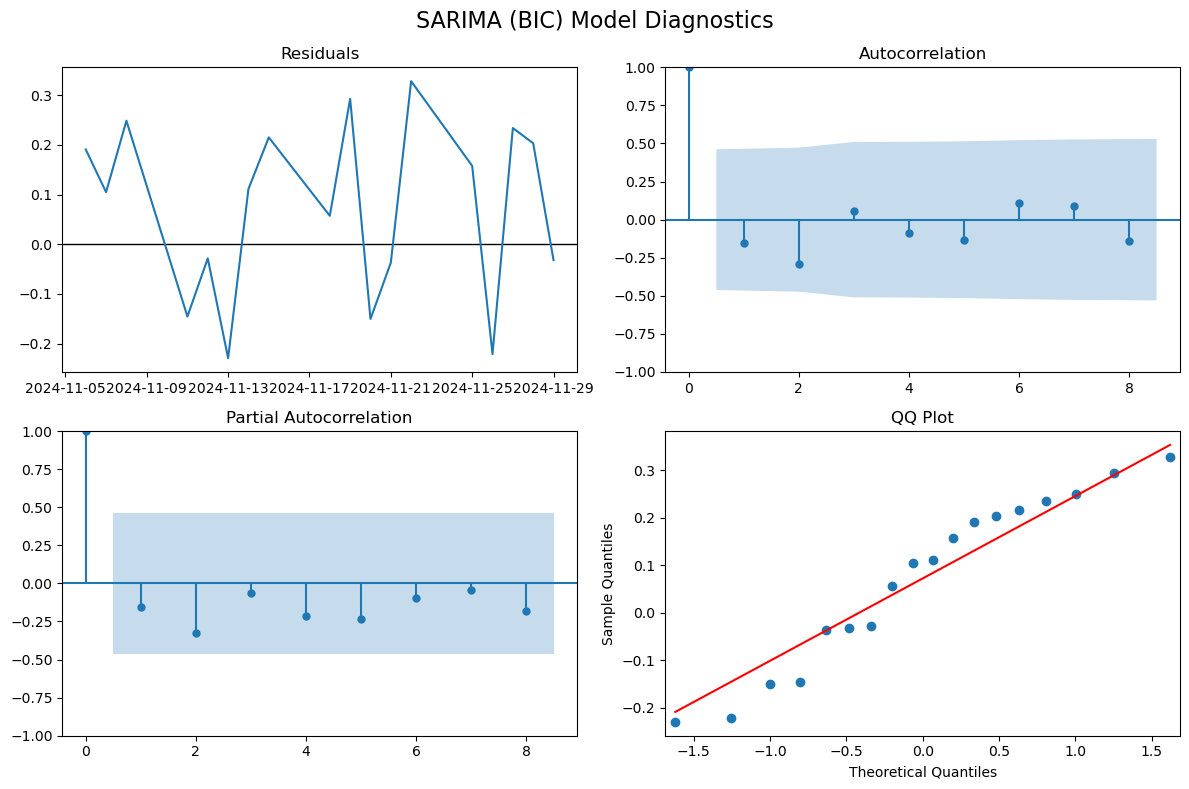

In [157]:
sarima_bic_resid = sarima_bic_model.resid()

if isinstance(sarima_bic_resid.index, pd.PeriodIndex):
    sarima_bic_resid.index = sarima_bic_resid.index.to_timestamp()

resid_no_initial_bic = sarima_bic_resid[6:]

# Plot residuals manually
fig_sarima_bic, ax_sarima_bic = plt.subplots(2, 2, figsize=(12, 8))
fig_sarima_bic.suptitle("SARIMA (BIC) Model Diagnostics", fontsize=16)
ax_sarima_bic[0, 0].axhline(0, color='black', lw=1)

# Plot residuals
ax_sarima_bic[0, 0].plot(resid_no_initial_bic)
ax_sarima_bic[0, 0].set_title("Residuals")

# ACF plot
sm.graphics.tsa.plot_acf(resid_no_initial_bic,
                         ax=ax_sarima_bic[0, 1], alpha=0.05, lags=8)

# PACF plot
sm.graphics.tsa.plot_pacf(resid_no_initial_bic,
                          ax=ax_sarima_bic[1, 0], alpha=0.05, lags=8)

# QQ plot
sm.qqplot(resid_no_initial_bic, line='s', ax=ax_sarima_bic[1, 1])
ax_sarima_bic[1, 1].set_title("QQ Plot")


plt.tight_layout()
plt.show()

##### Plotting SARIMA Model Forecasts

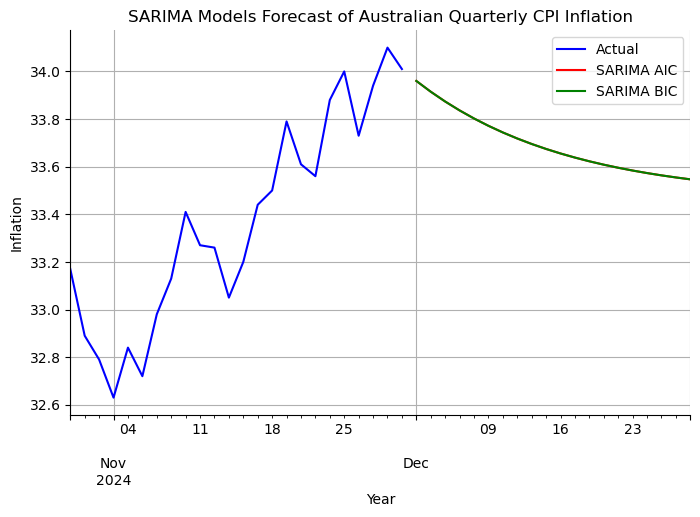

In [158]:
# Plot the forecast of the SARIMA model
fig_sarima_forecast, ax_sarima_forecast = plt.subplots(figsize=(8, 5))
closed_prices_1month.plot(color='b', ax=ax_sarima_forecast)
sarima_aic_model.predict(20).plot(color='r', ax=ax_sarima_forecast)
sarima_bic_model.predict(20).plot(color='g', ax=ax_sarima_forecast)
ax_sarima_forecast.set_xlabel('Year')
ax_sarima_forecast.set_ylabel('Inflation')
ax_sarima_forecast.set_title(
    'SARIMA Models Forecast of Australian Quarterly CPI Inflation')
sns.despine()
plt.legend(loc='best', labels=['Actual', 'SARIMA AIC', 'SARIMA BIC'])
plt.grid()
plt.show()

##### Model Evaluation

In [199]:
validation = closed_prices_1month['2024-11-20':].index
start = closed_prices_1month.index.get_loc('2024-11-20')

sarima_aic_pred = []
sarima_bic_pred = []

for i in range(start, len(closed_prices_1month)):

    sarima_aic_model_ = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                                 suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month.iloc[:i])

    sarima_aic_pred.append(sarima_aic_model_.predict(n_periods=20)[-1])

    sarima_bic_model_ = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                                 suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month.iloc[:i])

    sarima_bic_pred.append(sarima_bic_model_.predict(n_periods=20)[-1])

columns = ['SARIMA (AIC)', 'SARIMA (BIC)']
results = np.vstack([sarima_aic_pred, sarima_bic_pred]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [200]:
# Create a table to store the MSE values for each model
table = pd.DataFrame(0.0, index=results.columns, columns=['MSE']) 

# Calculate RMSE for each model compared to the actual values
for i in range(len(results.columns)):
    table.iloc[i, 0] = mean_squared_error(
        closed_prices_1month['2024-11-20':], results.iloc[:, i])

table = table.round(3)

table.sort_values(by='MSE', inplace=True)

table

,MSE
SARIMA (AIC),0.246
SARIMA (BIC),0.246


##### Picking the Best Model

In [201]:
best_model = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                        suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month)

horizon = 20

test = pd.date_range(
    start=closed_prices_1month.index[-1], periods=horizon + 1, freq='D')

forecast = pd.Series(best_model.predict(
    n_periods=horizon), index=test).round(4)

closed_prices_1month_forecast = pd.DataFrame(
    forecast.values,
    index=forecast.index,
    columns=['Closed Prices']
)

closed_prices_1month_forecast

,Closed Prices
2024-11-29 00:00:00+11:00,NaN
2024-11-30 00:00:00+11:00,NaN
2024-12-01 00:00:00+11:00,NaN
2024-12-02 00:00:00+11:00,33.9601
2024-12-03 00:00:00+11:00,33.9148
2024-12-04 00:00:00+11:00,33.8737
2024-12-05 00:00:00+11:00,33.8363
2024-12-06 00:00:00+11:00,33.8024
2024-12-07 00:00:00+11:00,NaN
2024-12-08 00:00:00+11:00,NaN


## Data for 1 year